# Paper Grading Assistant

## Modeling

Data comes from this link:
- https://components.one/datasets/all-the-news-2-news-articles-dataset/

Heavy inspiration drawn from:
- https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
(Use incognito window when opening that link)

In [1]:
# !pip install gensim
import os, sys
from gensim import corpora, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re


In [2]:
# Helper Functions
# Run the utilty functions from a seperate notebook
%run topic_model_utils.ipynb

def strip_html(raw_html):
    clean_re = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    clean_re2 = re.compile('\n|\t')
    text = re.sub(clean_re, '', raw_html)
    text = re.sub(clean_re2, ' ', text)
    return text

def grab_text(path):
    text = []
    paragraph = ''
    with open(path) as file:
        for line in file:
            if len(paragraph.split()) < 30:
                paragraph = paragraph + ' \n ' + strip_html(line.strip())
            else:
                paragraph = paragraph + ' \n ' + strip_html(line.strip())
                text.append(paragraph)
                paragraph = ''
    file.close()
    return text

def clean_big_file(file):
    data = []
    count = 0
    
    with open(file, newline='', encoding='utf-8') as csv_file:
        try:
            for line in csv_file:
                if count < 5*1000:
                    data.append(line)
                    count += 1
                else:
                    break
        except:
            print("Unexpected error:", sys.exc_info())
            count += 1
            pass
    csv_file.close()
    header = data.pop(0)
    return data

def clean_list(lst):
    print('processing text data...')
    clean_text = []
    for i in range(len(lst)):
        try:
            lst[i] = lst[i].strip()
            if len(lst[i]) < 2: # removes random empty lines
                lst.pop(i)
                continue
            text = strip_html(lst[i])
            text = process_text(text)
            clean_text.append(text)
        except IndexError:
            break
        except:
            print("Unexpected error:", sys.exc_info())
            pass
#     print(clean_text)
    return clean_text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# data = grab_text("D:\\Kaggle\\paul-graham-essays\\paul_graham_essay.txt")
data = clean_big_file("D:\\Kaggle\\all-the-news-2-1\\all-the-news-2-1.csv")
data = np.array(data)
print(data.shape)
df = pd.DataFrame()
df['texts'] = data
df['word_count'] = df['texts'].apply(word_count)
df['texts'] = df['texts'].apply(lambda x: x.lstrip('0123456789.-,: '))
df["id"] = df.index + 1
df.head(20)


(4999,)


,texts,word_count,id
0,"Lee Drutman,We should take concerns about the ...",1109,1
1,"Scott Davis,Colts GM Ryan Grigson says Andrew ...",277,2
2,\n,1,3
3,\n,1,4
4,\n,1,5
5,\n,1,6
6,\n,1,7
7,\n,1,8
8,\n,1,9
9,\n,1,10


In [4]:
df_filtered = df[df['word_count'] > 50]
df_filtered

,texts,word_count,id
0,"Lee Drutman,We should take concerns about the ...",1109,1
1,"Scott Davis,Colts GM Ryan Grigson says Andrew ...",277,2
12,"Trump denies report he ordered Mueller fired,""...",92,13
13,France's Sarkozy reveals his 'Passions' but in...,398,14
14,Paris Hilton: Woman In Black For Uncle Monty's...,83,15
...,...,...,...
4865,"""""Health specialists and engineers may secure ...",132,4866
4892,"""""Singapore is popular with finance industry p...",129,4893
4923,"""""Hong Kong has less favourable working condit...",151,4924
4950,"""""Canada is one of the most affordable countri...",130,4951


<AxesSubplot:>

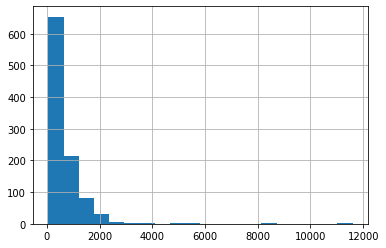

In [5]:
df_filtered['word_count'].hist(bins=20)

In [6]:
df_filtered['processed_texts'] = df_filtered['texts'].apply(process_text)
df_filtered

<ipython-input-6-c94917af5acd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['processed_texts'] = df_filtered['texts'].apply(process_text)


,texts,word_count,id,processed_texts
0,"Lee Drutman,We should take concerns about the ...",1109,1,"[lee, drutman, concern, health, liberal, democ..."
1,"Scott Davis,Colts GM Ryan Grigson says Andrew ...",277,2,"[scott, davis, colt, gm, ryan, grigson, andrew..."
12,"Trump denies report he ordered Mueller fired,""...",92,13,"[trump, denies, report, ordered, mueller, fire..."
13,France's Sarkozy reveals his 'Passions' but in...,398,14,"[france, sarkozy, reveals, passion, insists, c..."
14,Paris Hilton: Woman In Black For Uncle Monty's...,83,15,"[paris, hilton, woman, black, uncle, montys, f..."
...,...,...,...,...
4865,"""""Health specialists and engineers may secure ...",132,4866,"[health, specialist, engineer, secure, visa, e..."
4892,"""""Singapore is popular with finance industry p...",129,4893,"[singapore, popular, finance, industry, profes..."
4923,"""""Hong Kong has less favourable working condit...",151,4924,"[hong, kong, le, favourable, working, conditio..."
4950,"""""Canada is one of the most affordable countri...",130,4951,"[canada, affordable, country, live, work, fore..."


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, 
                                   min_df=3, 
                                   max_features=no_features, 
                                   stop_words='english', 
                                   preprocessor=' '.join)
tfidf = tfidf_vectorizer.fit_transform(df_filtered['processed_texts'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, 
                                min_df=3, 
                                max_features=no_features, 
                                stop_words='english', 
                                preprocessor=' '.join)
tf = tf_vectorizer.fit_transform(df_filtered['processed_texts'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [8]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 10

# Run NMF
nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


In [9]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
nmf_docweights = nmf.transform(tfidf_vectorizer.transform(df_filtered['processed_texts']))

n_top_words = 20

nmf_topic_df = topic_table(
    nmf,
    tfidf_feature_names,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
nmf_topic_df['topics'] = nmf_topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
nmf_topic_df['topics'] = nmf_topic_df['topics'].str[0]  # Removing the list brackets
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
nmf_topic_df['topics'] = nmf_topic_df['topics'].str[0]  # Removing the list brackets

nmf_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,topics
0,people,time,year,think,new,way,woman,make,thing,really,...,know,want,right,world,told,going,police,day,vice,people time year think new way woman make thin...
1,trump,president,donald,campaign,meeting,white,mueller,russian,russia,policy,...,house,administration,obama,speech,report,country,washington,election,official,trump president donald campaign meeting white ...
2,film,movie,million,critic,box,budget,fan,office,review,released,...,time,later,audience,cast,dark,list,success,today,studio,film movie million critic box budget fan offic...
3,company,billion,bank,year,percent,oil,google,million,market,business,...,price,rate,sale,share,data,investor,new,reporting,industry,company billion bank year percent oil google m...
4,china,chinese,trade,beijing,tariff,south,united,state,korea,huawei,...,kong,news,north,washington,talk,war,korean,editing,military,china chinese trade beijing tariff south unite...


In [10]:
# Do the same with bag of words weight
# to create 'topics'

lda_docweights = lda.transform(tf_vectorizer.transform(df_filtered['processed_texts']))

n_top_words = 20

lda_topic_df = topic_table(
    lda,
    tf_feature_names,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
lda_topic_df['topics'] = lda_topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
lda_topic_df['topics'] = lda_topic_df['topics'].str[0]  # Removing the list brackets
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
lda_topic_df['topics'] = lda_topic_df['topics'].str[0]  # Removing the list brackets

lda_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,topics
0,art,artist,work,museum,exhibition,new,painting,hyperallergic,gallery,image,...,film,video,maduro,project,york,space,year,th,century,art artist work museum exhibition new painting...
1,think,right,korea,south,north,know,trump,thing,don,yeah,...,nuclear,really,people,good,korean,shutdown,talk,time,want,think right korea south north know trump thing...
2,trump,president,people,country,time,government,american,campaign,new,policy,...,group,school,year,state,make,donald,support,way,plan,trump president people country time government...
3,trump,president,state,court,news,china,told,government,official,report,...,investigation,house,case,federal,reporting,washington,department,security,white,trump president state court news china told go...
4,people,health,drug,study,risk,percent,care,patient,year,medical,...,research,disease,lead,new,use,child,need,make,state,people health drug study risk percent care pat...


In [11]:

# Create a df with only the created topics and topic num
lda_topic_df = lda_topic_df['topics'].reset_index()
lda_topic_df.columns = ['lda_topic_num', 'topics']

lda_topic_df.head(30)

,lda_topic_num,topics
0,0,art artist work museum exhibition new painting...
1,1,think right korea south north know trump thing...
2,2,trump president people country time government...
3,3,trump president state court news china told go...
4,4,people health drug study risk percent care pat...
5,5,time people year new make way think thing game...
6,6,ford email kavanaugh clinton fbi flight plane ...
7,7,republican democrat house vote election party ...
8,8,police people facebook city right law state pr...
9,9,company year billion new percent bank market m...


In [12]:

# Create a df with only the created topics and topic num
nmf_topic_df = nmf_topic_df['topics'].reset_index()
nmf_topic_df.columns = ['nmf_topic_num', 'topics']

nmf_topic_df.head(30)

,nmf_topic_num,topics
0,0,people time year think new way woman make thin...
1,1,trump president donald campaign meeting white ...
2,2,film movie million critic box budget fan offic...
3,3,company billion bank year percent oil google m...
4,4,china chinese trade beijing tariff south unite...
5,5,art artist museum painting exhibition work gal...
6,6,facebook user company video instagram medium s...
7,7,eu brexit minister government european britain...
8,8,game player season sport team play battle vide...
9,9,republican democrat house vote senate democrat...


In [13]:
# Creating a temp df with the url and topic num to join on
id_ = df_filtered['id'].tolist()
df_temp1 = pd.DataFrame({
    'id': id_,
    'nmf_topic_num': nmf_docweights.argmax(axis=1)
})

merged_topic1 = df_temp1.merge(
    nmf_topic_df,
    on='nmf_topic_num',
    how='left'
)

df_temp2 = pd.DataFrame({
    'id': id_,
    'lda_topic_num': lda_docweights.argmax(axis=1)
})

merged_topic2 = df_temp2.merge(
    lda_topic_df,
    on='lda_topic_num',
    how='left'
)

# Merging to get the topic num with url
merged_topic = merged_topic1.merge(
    merged_topic2,
    on='id',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df_filtered,
    merged_topic,
    on='id',
    how='left'
)

df_topics = df_topics.drop(
    'processed_texts',
    axis=1
)

df_topics = df_topics.rename(columns={'topics_x' : 'nmf_topic', 'topics_y' : 'lda_topic' })

df_topics.head(15)

,texts,word_count,id,nmf_topic_num,nmf_topic,lda_topic_num,lda_topic
0,"Lee Drutman,We should take concerns about the ...",1109,1,0,people time year think new way woman make thin...,4,people health drug study risk percent care pat...
1,"Scott Davis,Colts GM Ryan Grigson says Andrew ...",277,2,3,company billion bank year percent oil google m...,5,time people year new make way think thing game...
2,"Trump denies report he ordered Mueller fired,""...",92,13,1,trump president donald campaign meeting white ...,3,trump president state court news china told go...
3,France's Sarkozy reveals his 'Passions' but in...,398,14,7,eu brexit minister government european britain...,3,trump president state court news china told go...
4,Paris Hilton: Woman In Black For Uncle Monty's...,83,15,0,people time year think new way woman make thin...,5,time people year new make way think thing game...
5,"""ECB's Coeure: If we decide to cut rates, we'd...",143,16,3,company billion bank year percent oil google m...,9,company year billion new percent bank market m...
6,"""Venezuela detains six military, police offici...",357,18,0,people time year think new way woman make thin...,8,police people facebook city right law state pr...
7,"Caroline Williams,You Can Trick Your Brain Int...",1820,19,0,people time year think new way woman make thin...,5,time people year new make way think thing game...
8,"Mark Bergen,How to watch the Google I/O keynot...",161,20,3,company billion bank year percent oil google m...,5,time people year new make way think thing game...
9,"Tim Hume,China is dismissing unfavorable media...",843,21,4,china chinese trade beijing tariff south unite...,3,trump president state court news china told go...


In [14]:

A = tfidf_vectorizer.transform(df_topics['texts'])
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
print('Sum of the squared residuals is {}'.format(sum_sqrt_res))

A = 999 x 1000
W = 10 x 1000
H = 999 x 10
Sum of the squared residuals is 0.0


In [15]:
def add_carriage_returns(text):
    arr = text.split(' ')
    for i in range(len(arr)):
        if i % 10 == 0:
            arr.insert(i, '\n')
    text = " ".join(arr)
    return text

df_topics['texts'] = df_topics['texts'].apply(add_carriage_returns)

def print_lines(idx):
    print('=====')
    print('entry: ', idx)
    print(df_topics['texts'][idx])
    print(' ')
    print('Topics:')
    print("nmf topics:", df_topics['nmf_topic'][idx])
    print("lda topics:", df_topics['lda_topic'][idx])
    print('=====')

for i in range(0,20):
    print_lines(i)

=====
entry:  0

 Lee Drutman,We should take concerns about the health of 
 liberal democracy seriously,"This post is part of Polyarchy, an 
 independent blog produced by the political reform program at 
 New America, a Washington think tank devoted to developing 
 new ideas and new voices. Imagine you are an 
 otherwise healthy 30-something who starts feeling weird. You are 
 sometimes short of breath. You get migraines. Your feet 
 start to swell a little. But otherwise, everything seems 
 fine. You go to the doctor. The doctor runs 
 some tests. She tells you, It's probably nothing, but these 
 could be signs of a coming heart attack. You 
 push for more certainty, but the doctor tells you 
 she's not sure. The human body is a complex 
 system. You're young and otherwise pretty healthy. There could 
 be plenty of other explanations for what you're feeling. 
 But it is a little worrying. So just to 
 be on the safe side, maybe you should reduce 
 the stress in your life and eat a hea

In [16]:
def build_wordcloud(feature_count, vectorizer):
    from wordcloud import WordCloud
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    n_entries = 20

    vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(n_entries)

    ax2.bar(x=vals_to_display.feat_name.values, height=vals_to_display.feat_count.values)

    # define a wordcloud
    wc = WordCloud(background_color="white")
    wc.generate(" ".join(vectorizer.get_feature_names()))

    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis("off")

    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.show()

In [17]:
tf_feature_count = pd.DataFrame({
    "feat_name": tf_feature_names, 
    "feat_count": tf.toarray().sum(axis=0).tolist()
})
tf_feature_count.sort_values(by='feat_count', ascending=False).head(20)


,feat_name,feat_count
636,people,1603
994,year,1519
916,trump,1466
902,time,1358
586,new,1255
851,state,913
525,make,800
965,way,764
896,think,717
674,president,712


In [18]:
tfidf_feature_count = pd.DataFrame({
    "feat_name": tfidf_feature_names, 
    "feat_count": tfidf.toarray().sum(axis=0).tolist()
})
tfidf_feature_count.sort_values(by='feat_count', ascending=False).head(20)

,feat_name,feat_count
916,trump,40.557813
636,people,32.629036
994,year,32.626822
902,time,28.943922
586,new,28.794917
314,film,25.047502
556,million,23.547063
165,company,23.231695
851,state,22.555173
674,president,20.136082


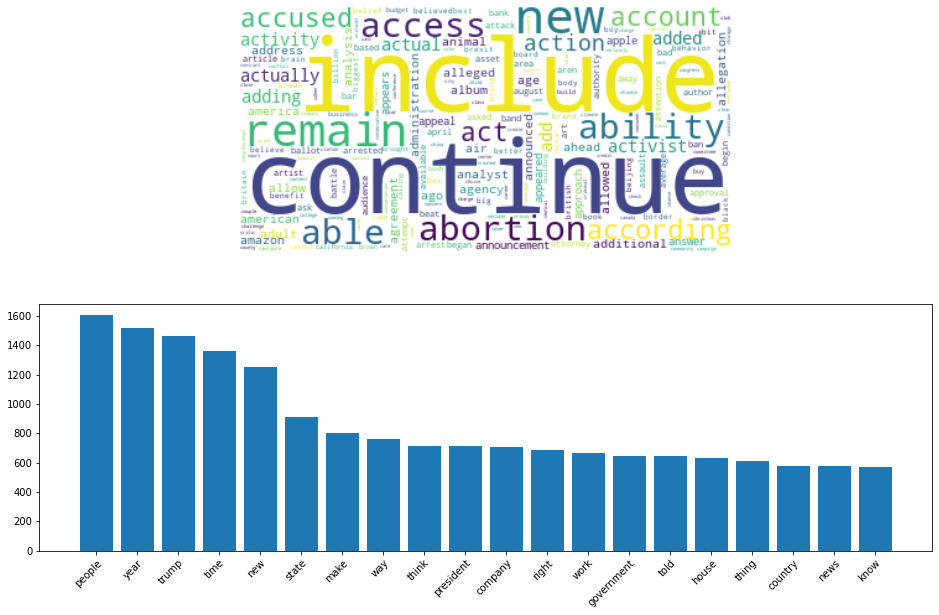

In [19]:
build_wordcloud(tf_feature_count, tf_vectorizer)

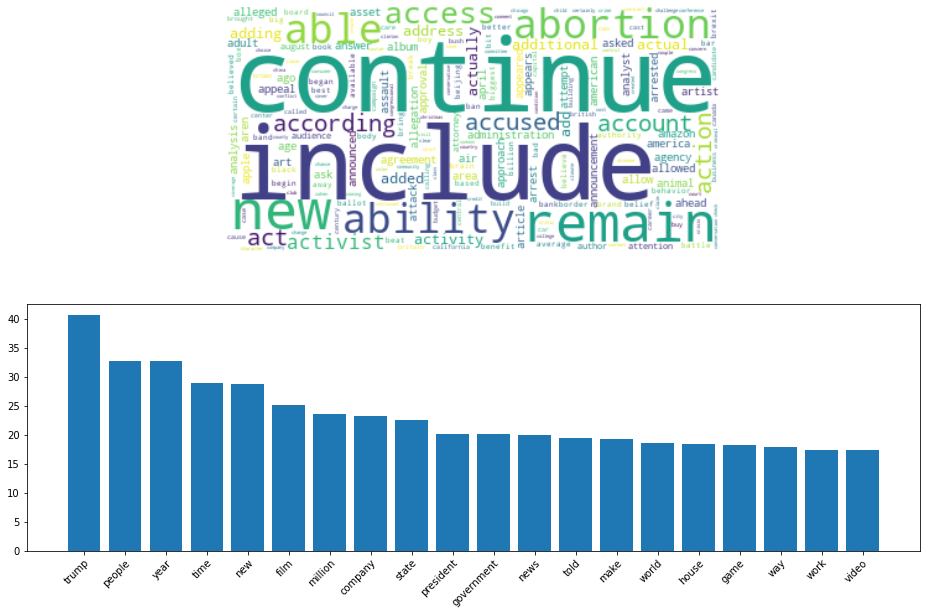

In [20]:
build_wordcloud(tfidf_feature_count, tfidf_vectorizer)

In [21]:
# train model on news set, and then 
# evaluate on paul graham data set

In [22]:
# look into hosting (flask vs streamlit)

In [ ]:
# train model for predicting essays
